In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def gen_data(num_data, seed = 2024):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: torch.cos(x)*torch.cos(y) - torch.sin(x)*torch.sin(y)
    latent_fn = data_fn(x, y)
    z = torch.heaviside(latent_fn - 0.5, torch.zeros(latent_fn.shape)).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

In [3]:
train_x, train_y, genfn = gen_data(500)

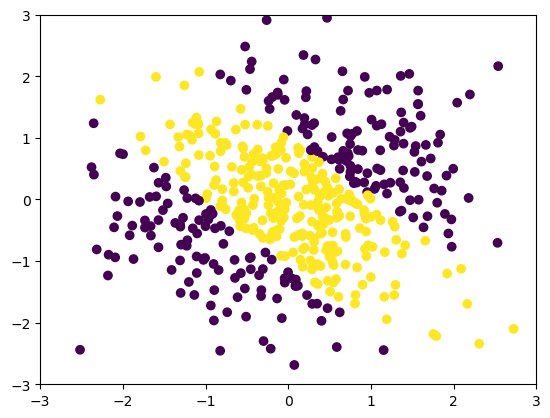

In [4]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y) 
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [5]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
# test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_latent  = genfn(test_x_mat, test_y_mat)
test_labels = torch.heaviside(test_latent - 0.5, torch.zeros(test_latent.shape))
test_y = test_labels.view(-1)

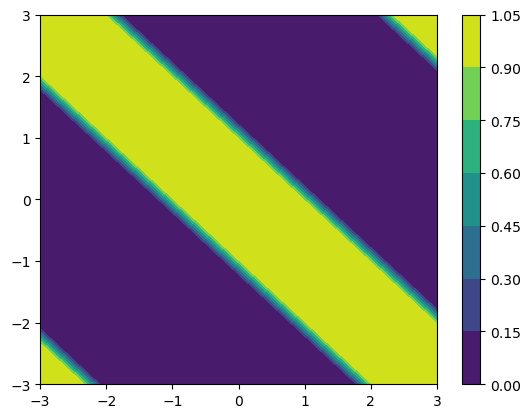

In [6]:
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
plt.colorbar()
plt.show()

In [7]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

In [8]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 4.187   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 3.948   lengthscale: 0.799   noise: 0.475
Iter 11/50 - Loss: 3.827   lengthscale: 0.848   noise: 0.319
Iter 16/50 - Loss: 3.747   lengthscale: 0.819   noise: 0.214
Iter 21/50 - Loss: 3.694   lengthscale: 0.731   noise: 0.147
Iter 26/50 - Loss: 3.639   lengthscale: 0.594   noise: 0.105
Iter 31/50 - Loss: 3.543   lengthscale: 0.489   noise: 0.076
Iter 36/50 - Loss: 3.515   lengthscale: 0.402   noise: 0.055
Iter 41/50 - Loss: 3.497   lengthscale: 0.381   noise: 0.041
Iter 46/50 - Loss: 3.469   lengthscale: 0.423   noise: 0.031


In [10]:
model.eval() # calculates latent variable 'f' (logits) bcoz we used DirichletGP
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)   # gives a multi-variate normal distribution at each test_x point
                                # number of variables = number of classes

    pred_means = test_dist.loc  # loc method comes from pytorch distrubutions; is equal to mean 
    pred_stddevs = test_dist.stddev

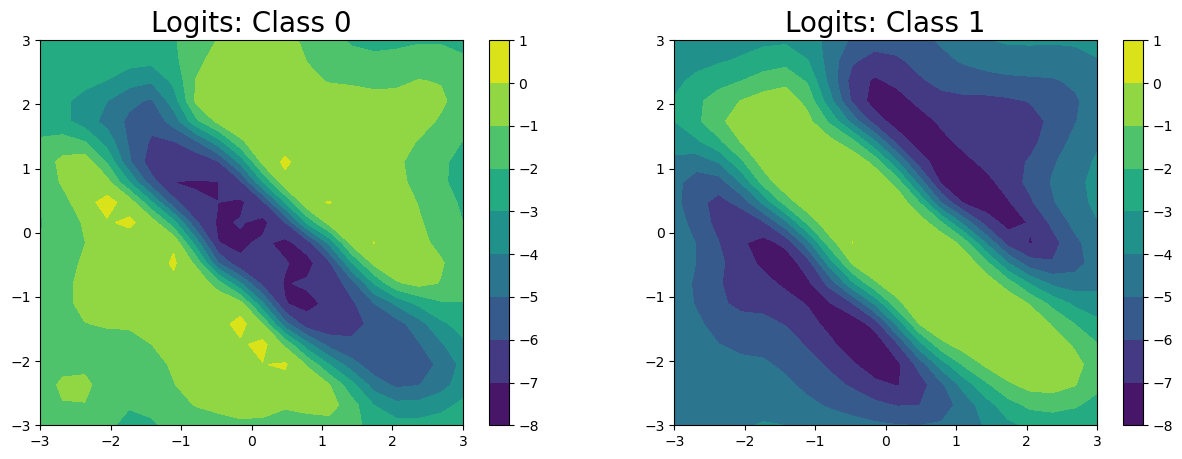

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [12]:
# calculate expected value of class probabilites; this is done by sampling 256 points and taking average
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/home/gouravk/miniconda3/envs/gpytorch/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/gouravk/miniconda3/envs/gpytorch/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


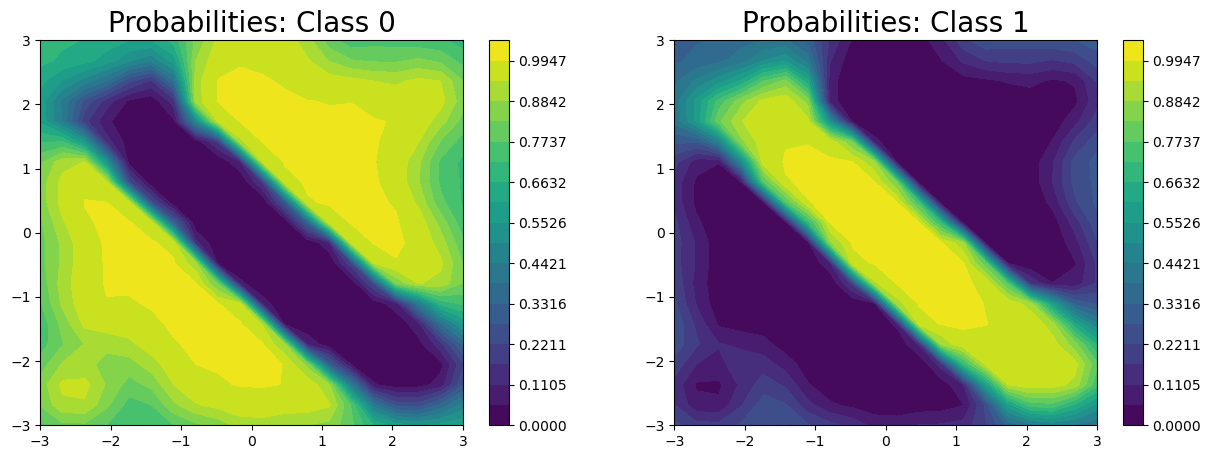

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

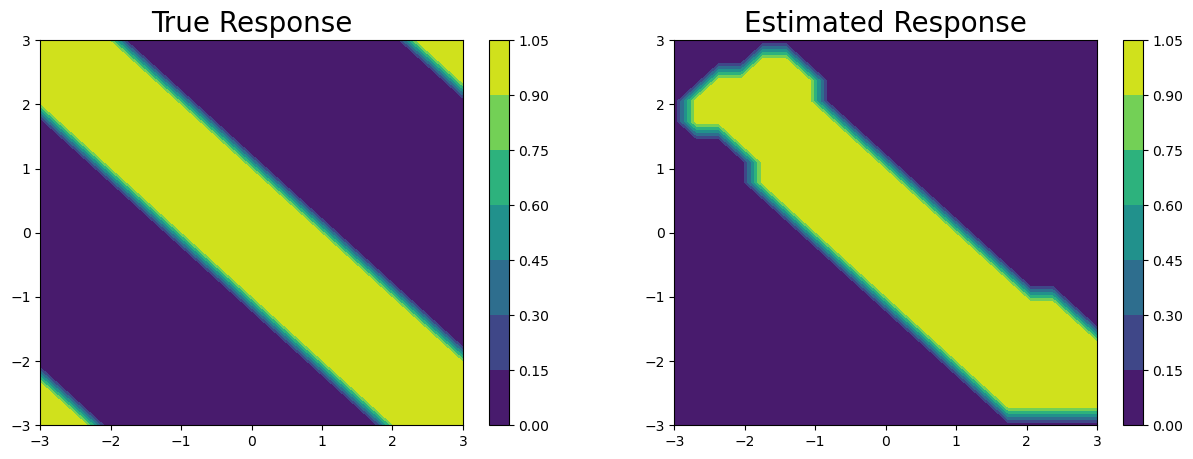

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

im1 = ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)
fig.colorbar(im1, ax = ax[0])

im2 = ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)
fig.colorbar(im2, ax=ax[1])

plt.show()

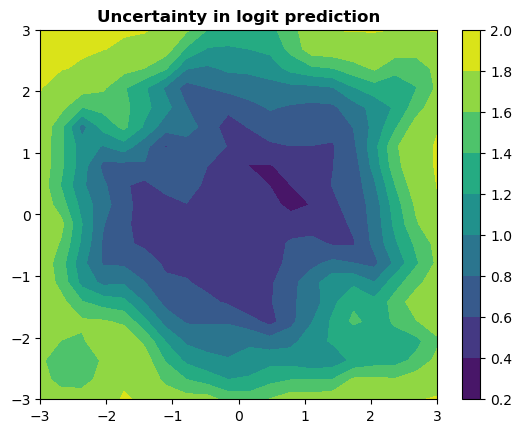

In [18]:
#plot prediction uncertainty
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_stddevs.max(0)[0].reshape((20,20)))
plt.title('Uncertainty in logit prediction', fontweight='bold')
plt.colorbar()
plt.show()